## Выбор модели для задач классификации

Для задач классификации существует несколько способов выбора модели:

1. **Обучить маленькую модель с нуля**: Выбор легковесной архитектуры модели и полное обучение её на нашем наборе данных.
2. **Fine-Tuning предобученной модели**: Используем модель, которая была предобучена авторами на другом наборе данных, и только последние слои переобучается на нашем конкретном наборе данных.
3. **Использовать предобученные веса напрямую**: В этом методе используется предобученная модель без дополнительного обучения.

Лучшим вариантом является Fine-Tuning, поэтому в качестве бейзлайна возьмем маленькую (5.3M) EfficientNet B0 с претрейновыми параметрами

[Оригинальная статья](https://arxiv.org/abs/1905.11946)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import os
import zipfile
import json
import shutil
import time

In [ ]:
directory_path = '/content/dataset'

if os.path.exists(directory_path):
    shutil.rmtree(directory_path)
    print(f"Директория {directory_path} успешно удалена.")
else:
    print(f"Директория {directory_path} не существует.")

Директория /content/dataset не существует.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# drive.flush_and_unmount()

In [ ]:
# Загрузка гиперпараметров из JSON (создайте папку classification, если её еще нет в корне диска Google Drive)
with open('/content/drive/MyDrive/classification/hyperparams.json', "r") as f:
  hyperparams = json.load(f)

In [ ]:
# Загрузка названий классов из JSON
with open("/content/drive/MyDrive/classification/class_to_idx.json", "r")  as f:
  class_to_idx = json.load(f)


**Структура** c*lassification_dataset.zip*: (внутри папка с таким же названием)

```
classification_dataset/
├── train/
│   ├── class_name1/
│   └── class_name2/
│   └── ...

└── test/
    ├── class_name1/
    └── class_name2/
    └── ...
```



In [ ]:
local_zip = '/content/drive/MyDrive/classification/classification_dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/dataset')
zip_ref.close()

In [ ]:
# Класс для аугментации данных
class AugmentedDataset(Dataset):
    def __init__(self, original_folder, target_size=50, transform=None):
        self.transform = transform
        self.samples = []
        self.class_to_idx = class_to_idx

        # Проверяем, что все классы из JSON есть в папке
        class_names = os.listdir(original_folder)
        missing_classes = [cls for cls in class_to_idx.keys() if cls not in class_names]
        if missing_classes:
            raise ValueError(f"Классы {missing_classes} из class_to_idx.json отсутствуют в папке {original_folder}")

        # Собираем пути к изображениям для каждого класса
        for class_name in class_names: # Используем отсортированные имена классов
            class_path = os.path.join(original_folder, class_name)
            images = [os.path.join(class_path, img) for img in os.listdir(class_path)]
            # Повторяем изображения до достижения целевого размера
            for i in range(target_size):
                self.samples.append((images[i % len(images)], class_name))

    # Возвращает общее количество элементов в наборе данных
    def __len__(self):
        return len(self.samples)

    # Возвращает одно изображение и его метку по индексу
    def __getitem__(self, idx):
        img_path, class_name = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        # Применяем аугментации
        if self.transform:
            image = self.transform(image)

        # Преобразуем метку класса в числовой формат
        label = self.class_to_idx[class_name]  # Преобразуем имя класса в индекс
        return image, label  # Оставляем числовую метку для обучения

In [ ]:
# Класс для создания датасета под Test выборку
class TestDataset(Dataset):
    def __init__(self, original_folder, transform=None):
        self.transform = transform
        self.samples = []
        self.class_to_idx = class_to_idx  # Загружаем метки классов из JSON

        # Проверяем, что все классы из JSON есть в папке
        class_names = os.listdir(original_folder)
        missing_classes = [cls for cls in class_to_idx.keys() if cls not in class_names]
        if missing_classes:
            raise ValueError(f"Классы {missing_classes} из class_to_idx.json отсутствуют в {original_folder}")

        # Собираем пути к изображениям
        for class_name in class_names:
            class_path = os.path.join(original_folder, class_name)
            images = [os.path.join(class_path, img) for img in os.listdir(class_path)]
            for img_path in images:
                self.samples.append((img_path, class_name))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, class_name = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        # Применяем трансформации (без аугментаций)
        if self.transform:
            image = self.transform(image)

        # Преобразуем имя класса в индекс
        label = self.class_to_idx[class_name]
        return image, label

In [ ]:
def create_dataloaders(
    train_dir,
    test_dir,
    hyperparams,
    target_size=50,
    image_size=224
):
    """
    Создает DataLoader'ы для обучающих и тестовых данных.

    Args:
        train_dir: Путь к папке с обучающими данными.
        test_dir: Путь к папке с тестовыми данными.
        hyperparams: Словарь с гиперпараметрами, включая 'batch_size'.
        target_size: Целевой размер для аугментации данных.
        image_size: Размер, до которого будут изменяться изображения (width, height).

    Returns:
        train_loader, test_loader, train_dataset, test_dataset: DataLoader'ы и датасеты для обучающих и тестовых данных.
    """

    train_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    test_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Создание аугментированных датасетов
    train_dataset = AugmentedDataset(
        original_folder=train_dir,
        target_size=target_size,
        transform=train_transform
    )

    test_dataset = TestDataset(
        original_folder=test_dir,
        transform=test_transform
    )

    # DataLoader'ы
    train_loader = DataLoader(
        train_dataset,
        batch_size=hyperparams['batch_size'],
        shuffle=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=hyperparams['batch_size'],
        shuffle=False
    )

    return train_loader, test_loader, train_dataset, test_dataset

In [ ]:
train_loader, test_loader, train_dataset, test_dataset = create_dataloaders(
    train_dir='/content/dataset/classification_dataset/train',
    test_dir='/content/dataset/classification_dataset/test',
    hyperparams=hyperparams,
    target_size=50,
    image_size=224
)

In [ ]:
# Проверим классы
test_dataset.class_to_idx

{'dog': 0, 'cat': 1}

In [ ]:
# Создание обратного словаря idx_to_class
idx_to_class = {v: k for k, v in class_to_idx.items()}

In [ ]:
# Загрузка модели EfficientNet
model = efficientnet_b0(EfficientNet_B0_Weights.DEFAULT)

# Заморозка всех слоев, кроме последнего
for param in model.parameters():
    param.requires_grad = False

# Замена финального классификатора
num_features = model.classifier[1].in_features
num_classes = len(class_to_idx)  # Количество классов из JSON
model.classifier = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Linear(128, num_classes),  # Многоклассовая классификация
    # На выходе оставляем сырые логиты, так как nn.CrossEntropyLoss() их ожидает на вход
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 118MB/s] 


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()  # Для многоклассовой классификации
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=hyperparams['learning_rate'],
    weight_decay=hyperparams['weight_decay']
)

### Фунция для расчета метрик классификации

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

In [ ]:
def evaluate_model(model, data_loader, criterion, device):
  """
  Оценивает модель, возвращая словарь различных метрик
  (Accuracy, f1_Score, precision, recall etc.)
  """
  model.eval()
  val_loss = 0.0
  correct = 0
  total = 0
  all_preds = []
  all_labels = []


  with torch.no_grad():
    for images, labels in data_loader:
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)
      val_loss += loss.item() * images.size(0)

      _, predicted = torch.max(outputs.data, 1)
      correct += (predicted == labels).sum().item()
      total += labels.size(0)

      all_preds.extend(predicted.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())



    # Расчет метрик

    accuracy = correct / total
    avg_loss = val_loss / len(data_loader.dataset)


    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

    class_report = classification_report(all_labels, all_preds, zero_division=0, output_dict=True)
    conf_matrix = confusion_matrix(all_labels, all_preds)



  return {
      'loss': avg_loss,
      'accuracy': accuracy,
      'f1_score': f1,
      'precision': precision,
      'recall': recall,
      'class_report': class_report,
      'confusion_matrix': conf_matrix,
      'predictions': all_preds,
      'ground_truth': all_labels
  }



### Функции для визуализации

In [ ]:
import seaborn as sns

In [ ]:
def plot_training_history(train_metrics, val_metrics, metric_name='loss'):
    """
    Строит графики выбранной метрики на протяжении эпох обучения.

    Args:
        train_metrics: Список значений метрики на обучающей выборке
        val_metrics: Список значений метрики на валидационной выборке
        metric_name: Название метрики для отображения
    """
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(train_metrics) + 1)

    plt.plot(epochs, train_metrics, 'b-', label=f'Тренировка {metric_name}')
    plt.plot(epochs, val_metrics, 'r-', label=f'Валидация {metric_name}')

    plt.title(f'Тренировка и валидация {metric_name.capitalize()}')
    plt.xlabel('Эпохи')
    plt.ylabel(metric_name.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_confusion_matrix(cm, class_names):
    """
    Визуализирует матрицу ошибок.

    Args:
        cm: Матрица ошибок
        class_names: Список названий классов
    """
    plt.figure(figsize=(10, 8))

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)

    plt.title('Нормализованная матрица ошибок')
    plt.ylabel('Истинный класс')
    plt.xlabel('Предсказанный класс')
    plt.tight_layout()
    plt.show()

def visualize_predictions(model, test_dataset, idx_to_class, device, num_samples=10):
    """
    Визуализирует предсказания модели на тестовых примерах.

    Args:
        model: Обученная модель
        test_dataset: Тестовый датасет
        idx_to_class: Словарь для преобразования индекса класса в название
        device: Устройство для выполнения вычислений
        num_samples: Количество примеров для визуализации
    """
    model.eval()

    indices = np.random.choice(len(test_dataset), num_samples, replace=False)

    fig, axes = plt.subplots(2, num_samples // 2, figsize=(20, 8))
    axes = axes.flatten()

    for i, idx in enumerate(indices):
        image, label = test_dataset[idx]

        img = image.cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        with torch.no_grad():
            output = model(image.unsqueeze(0).to(device))
            _, predicted = torch.max(output, 1)
            probabilities = torch.nn.functional.softmax(output, dim=1)
            confidence = probabilities[0][predicted[0]].item()

        axes[i].imshow(img)
        title_color = 'green' if predicted[0].item() == label else 'red'

        axes[i].set_title(f"Predicted: {idx_to_class[predicted[0].item()]}\n"
                         f"True: {idx_to_class[label]}\n"
                         f"Conf: {confidence:.2f}", color=title_color)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def plot_class_distribution(train_dataset, test_dataset, idx_to_class):
    """
    Визуализирует распределение классов в обучающем и тестовом наборах.
    """
    train_counts = {}
    test_counts = {}

    for _, label_name in train_dataset.samples:
        label = train_dataset.class_to_idx[label_name]
        train_counts[label] = train_counts.get(label, 0) + 1

    for _, label_name in test_dataset.samples:
        label = test_dataset.class_to_idx[label_name]
        test_counts[label] = test_counts.get(label, 0) + 1

    class_indices = sorted(idx_to_class.keys())
    class_names = [idx_to_class[i] for i in class_indices]

    train_values = [train_counts.get(i, 0) for i in class_indices]
    test_values = [test_counts.get(i, 0) for i in class_indices]

    fig, ax = plt.subplots(figsize=(12, 6))

    x = np.arange(len(class_indices))
    width = 0.35

    ax.bar(x - width/2, train_values, width, label='Train')
    ax.bar(x + width/2, test_values, width, label='Test')

    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_title('Распределение классов в наборах данных')
    ax.set_ylabel('Количество изображений')
    ax.legend()

    plt.tight_layout()
    plt.show()

### Обучение модели

In [ ]:
def log_gpu_memory(message="", reset_max=False):
    """
    Логирует текущее и максимальное использование GPU-памяти

    Args:
        message: Сообщение для логирования
        reset_max: Сбросить счетчик максимального использования
    """
    if torch.cuda.is_available():
        current_mem = torch.cuda.memory_allocated() / (1024 ** 2)  # МБ
        max_mem = torch.cuda.max_memory_allocated() / (1024 ** 2)  # МБ
        print(f"{message} - Текущая память GPU: {current_mem:.2f} МБ, Пиковая память: {max_mem:.2f} МБ")
        if reset_max:
            torch.cuda.reset_max_memory_allocated()
    else:
        print("CUDA недоступна")

In [ ]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device):
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'val_f1': [],
        'precision': [],
        'recall': []
    }

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0


        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

        avg_train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = train_correct / train_total

        metrics = evaluate_model(model, test_loader, criterion, device)

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(metrics['loss'])
        history['train_acc'].append(train_accuracy)
        history['val_acc'].append(metrics['accuracy'])
        history['val_f1'].append(metrics['f1_score'])

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
        print(
            f"Val Loss: {metrics['loss']:.4f}, Val Acc: {metrics['accuracy']:.4f}, Val F1: {metrics['f1_score']:.4f}, Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}"
            )
        print('-' * 60)

    return history, model

In [ ]:
# @title Текущее потребление памяти
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Максимальный объем памяти = {max_memory} ГБ.")
print(f"{start_gpu_memory} ГБ памяти зарезервировано.")

GPU = Tesla T4. Максимальный объем памяти = 14.741 ГБ.
0.033 ГБ памяти зарезервировано.


In [ ]:
start_time = time.time()

efficientnet_b0_history_50, efficientnet_b0_50 = train_model(
    model, train_loader, test_loader, criterion, optimizer,
    hyperparams['num_epochs'], device
)

train_runtime = time.time() - start_time

Epoch 1/10
Train Loss: 0.6874, Train Acc: 0.4700
Val Loss: 0.6660, Val Acc: 0.6670, Val F1: 0.6638, Precision: 0.6735, Recall: 0.6670
------------------------------------------------------------
Epoch 2/10
Train Loss: 0.6358, Train Acc: 0.7700
Val Loss: 0.6317, Val Acc: 0.7690, Val F1: 0.7666, Precision: 0.7804, Recall: 0.7690
------------------------------------------------------------
Epoch 3/10
Train Loss: 0.5913, Train Acc: 0.8800
Val Loss: 0.5902, Val Acc: 0.8590, Val F1: 0.8585, Precision: 0.8644, Recall: 0.8590
------------------------------------------------------------
Epoch 4/10
Train Loss: 0.5621, Train Acc: 0.8000
Val Loss: 0.5553, Val Acc: 0.8730, Val F1: 0.8725, Precision: 0.8786, Recall: 0.8730
------------------------------------------------------------
Epoch 5/10
Train Loss: 0.5082, Train Acc: 0.8800
Val Loss: 0.5222, Val Acc: 0.8810, Val F1: 0.8809, Precision: 0.8829, Recall: 0.8810
------------------------------------------------------------
Epoch 6/10
Train Loss: 0.

In [ ]:
# @title Потребление памяти после обучения
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_training = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
training_percentage = round(used_memory_for_training / max_memory * 100, 3)

# Выводим статистику
print(f"{train_runtime} секунд затрачено на обучение.")
print(
    f"{round(train_runtime/60, 2)} минут затрачено на обучение."
)
print(f"Пиковый объем зарезервированной памяти = {used_memory} ГБ.")
print(f"Пиковый объем зарезервированной памяти для обучения = {used_memory_for_training} ГБ.")
print(f"Пиковый объем зарезервированной памяти в % от максимальной памяти = {used_percentage} %.")
print(f"Пиковый объем зарезервированной памяти для обучения в % от максимальной памяти = {training_percentage} %.")

77.85105085372925 секунд затрачено на обучение.
1.3 минут затрачено на обучение.
Пиковый объем зарезервированной памяти = 0.178 ГБ.
Пиковый объем зарезервированной памяти для обучения = 0.145 ГБ.
Пиковый объем зарезервированной памяти в % от максимальной памяти = 1.208 %.
Пиковый объем зарезервированной памяти для обучения в % от максимальной памяти = 0.984 %.


In [ ]:
efficientnet_b0_metrics_50 = evaluate_model(efficientnet_b0_50, test_loader, criterion, device)

In [ ]:
efficientnet_b0_metrics_50["confusion_matrix"]

array([[440,  60],
       [ 35, 465]])

Довольно много примеров модель угадывает правильно даже при малом кол-ве сэмплов ( всего 50 на каждый класс )

In [ ]:
efficientnet_b0_metrics_50["class_report"]

{'0': {'precision': 0.9263157894736842,
  'recall': 0.88,
  'f1-score': 0.9025641025641026,
  'support': 500.0},
 '1': {'precision': 0.8857142857142857,
  'recall': 0.93,
  'f1-score': 0.9073170731707317,
  'support': 500.0},
 'accuracy': 0.905,
 'macro avg': {'precision': 0.9060150375939849,
  'recall': 0.905,
  'f1-score': 0.9049405878674172,
  'support': 1000.0},
 'weighted avg': {'precision': 0.9060150375939849,
  'recall': 0.905,
  'f1-score': 0.9049405878674172,
  'support': 1000.0}}

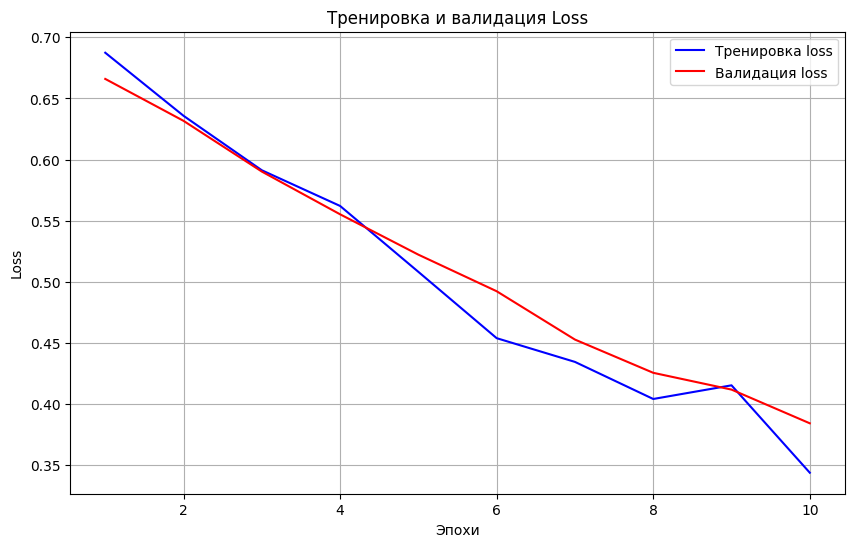

In [ ]:
plot_training_history(efficientnet_b0_history_50['train_loss'], efficientnet_b0_history_50['val_loss'], 'loss')

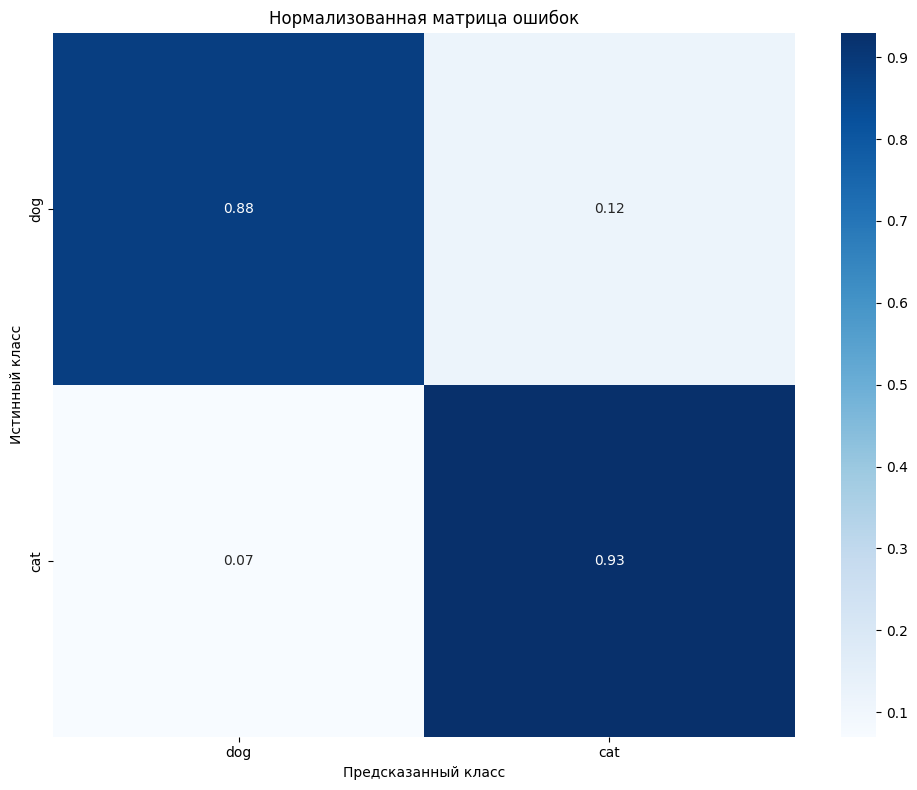

In [ ]:
plot_confusion_matrix(efficientnet_b0_metrics_50["confusion_matrix"], idx_to_class.values())

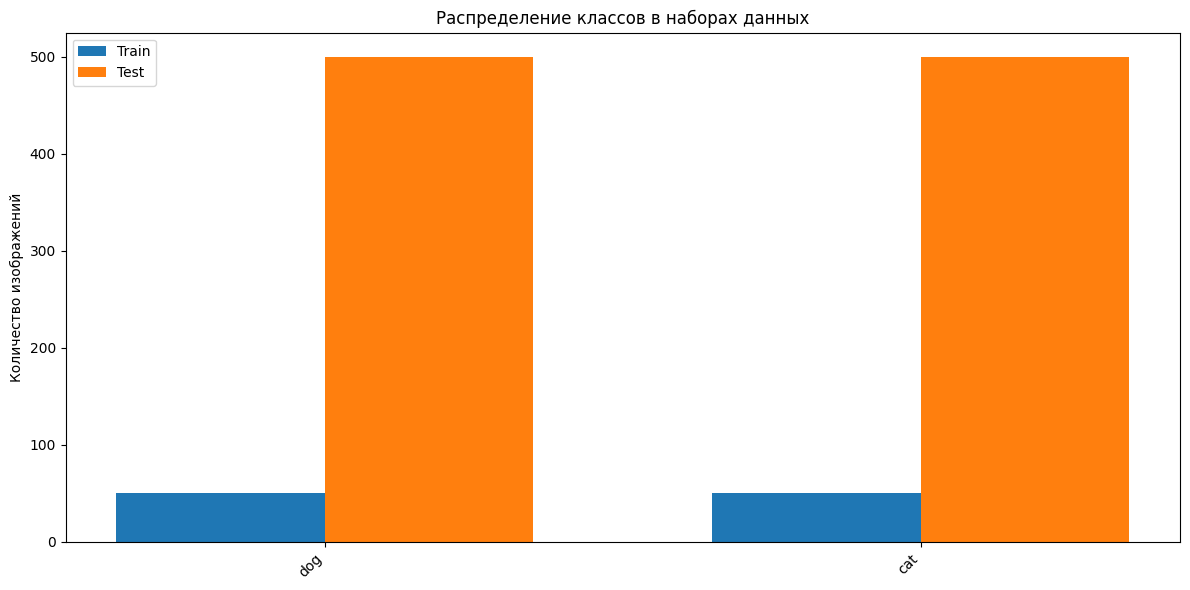

In [ ]:
plot_class_distribution(train_dataset, test_dataset, idx_to_class)

In [ ]:
benchmarks = {
    "efficientnet_b0_50": efficientnet_b0_metrics_50
}

Модель показывает отличные матрики на совсем малом кол-ве изображений в тренировочном датасете, попробуем снизить их до минимального кол-ва (15) по каждому из классов

*Сделаем замечание, что EfficentNet обучалась на датасете ImageNet, в котором уже присутсвовали данные классы, дальше попробуем обучаться на незнакомых модели классах*

In [ ]:
directory_path = '/content/dataset'

if os.path.exists(directory_path):
    shutil.rmtree(directory_path)
    print(f"Директория {directory_path} успешно удалена.")
else:
    print(f"Директория {directory_path} не существует.")

Директория /content/dataset успешно удалена.


In [ ]:
local_zip = '/content/drive/MyDrive/classification/classification_dataset_small.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/dataset')
zip_ref.close()

In [ ]:
train_loader, test_loader, train_dataset, test_dataset = create_dataloaders(
    train_dir='/content/dataset/classification_dataset/train',
    test_dir='/content/dataset/classification_dataset/test',
    hyperparams=hyperparams,
    target_size=50,
    image_size=224
)

In [ ]:
# Загрузка модели EfficientNet
model = efficientnet_b0(EfficientNet_B0_Weights.DEFAULT)

# Заморозка всех слоев, кроме последнего
for param in model.parameters():
    param.requires_grad = False

# Замена финального классификатора
num_features = model.classifier[1].in_features
num_classes = len(class_to_idx)  # Количество классов из JSON
model.classifier = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Linear(128, num_classes),  # Многоклассовая классификация
    # На выходе оставляем сырые логиты, так как nn.CrossEntropyLoss() их ожидает на вход
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()  # Для многоклассовой классификации
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=hyperparams['learning_rate'],
    weight_decay=hyperparams['weight_decay']
)

In [ ]:
efficientnet_b0_history_15, efficientnet_b0_15 = train_model(
    model, train_loader, test_loader, criterion, optimizer,
    hyperparams['num_epochs'], device
)

Epoch 1/10
Train Loss: 0.6957, Train Acc: 0.5000
Val Loss: 0.6592, Val Acc: 0.5370, Val F1: 0.4107, Precision: 0.7596, Recall: 0.5370
------------------------------------------------------------
Epoch 2/10
Train Loss: 0.6146, Train Acc: 0.7900
Val Loss: 0.6321, Val Acc: 0.6980, Val F1: 0.6715, Precision: 0.7923, Recall: 0.6980
------------------------------------------------------------
Epoch 3/10
Train Loss: 0.5555, Train Acc: 0.8900
Val Loss: 0.5961, Val Acc: 0.7720, Val F1: 0.7608, Precision: 0.8344, Recall: 0.7720
------------------------------------------------------------
Epoch 4/10
Train Loss: 0.4976, Train Acc: 0.9000
Val Loss: 0.5642, Val Acc: 0.8150, Val F1: 0.8116, Precision: 0.8398, Recall: 0.8150
------------------------------------------------------------
Epoch 5/10
Train Loss: 0.4353, Train Acc: 0.9500
Val Loss: 0.5311, Val Acc: 0.8530, Val F1: 0.8521, Precision: 0.8616, Recall: 0.8530
------------------------------------------------------------
Epoch 6/10
Train Loss: 0.

In [ ]:
efficientnet_b0_metrics_15 = evaluate_model(efficientnet_b0_15, test_loader, criterion, device)

In [ ]:
efficientnet_b0_metrics_15["confusion_matrix"]

array([[381, 119],
       [ 14, 486]])

In [ ]:
efficientnet_b0_metrics_15["class_report"]

{'0': {'precision': 0.9645569620253165,
  'recall': 0.762,
  'f1-score': 0.8513966480446927,
  'support': 500.0},
 '1': {'precision': 0.8033057851239669,
  'recall': 0.972,
  'f1-score': 0.8796380090497737,
  'support': 500.0},
 'accuracy': 0.867,
 'macro avg': {'precision': 0.8839313735746417,
  'recall': 0.867,
  'f1-score': 0.8655173285472333,
  'support': 1000.0},
 'weighted avg': {'precision': 0.8839313735746416,
  'recall': 0.867,
  'f1-score': 0.8655173285472332,
  'support': 1000.0}}

In [ ]:
benchmarks["efficientnet_b0_15"] = efficientnet_b0_metrics_15

In [ ]:
import pandas as pd

<Figure size 1400x800 with 0 Axes>

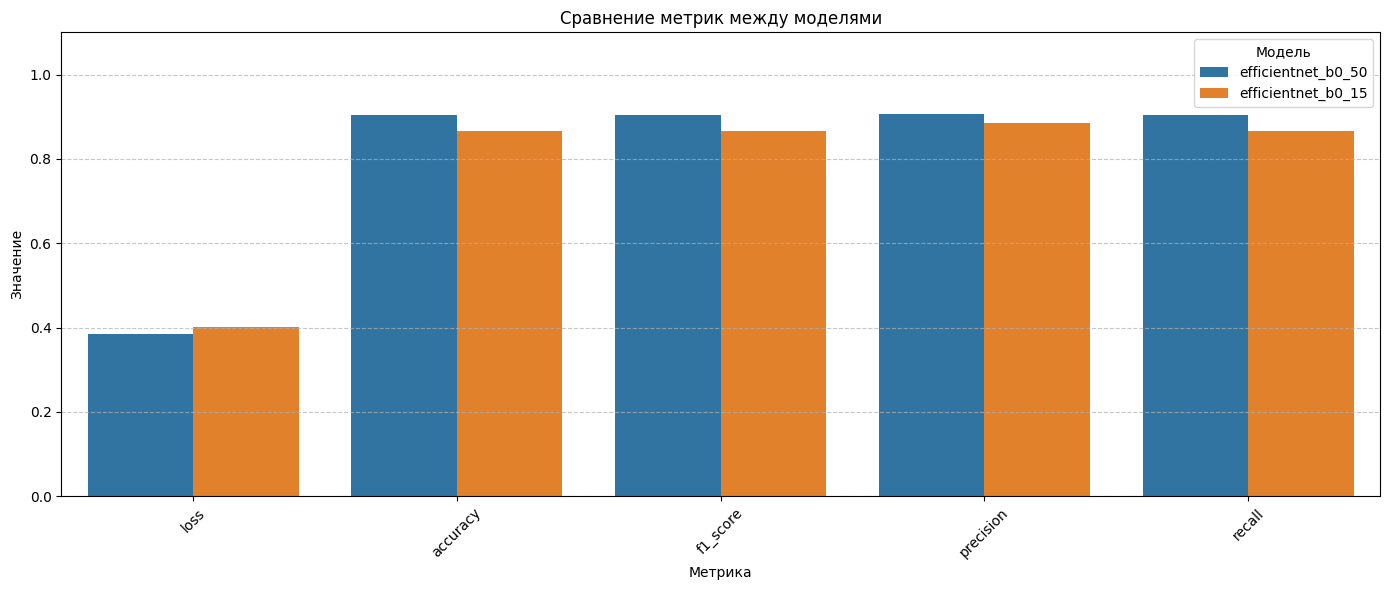

In [ ]:
def compare_benchmarks(benchmarks):
    """
    Сравнивает метрики между различными моделями в бенчмарке.

    Args:
        benchmarks: Словарь вида {имя_модели: словарь_метрик}
    """

    first_model = list(benchmarks.keys())[0]
    metrics_to_compare = [metric for metric, value in benchmarks[first_model].items()
                          if isinstance(value, (int, float)) and metric not in ['predictions', 'ground_truth']]

    comparison_data = []
    for model_name, metrics in benchmarks.items():
        model_data = {'Модель': model_name}
        for metric in metrics_to_compare:
            if metric in metrics and isinstance(metrics[metric], (int, float)):
                model_data[metric] = metrics[metric]
        comparison_data.append(model_data)

    df = pd.DataFrame(comparison_data)

    plt.figure(figsize=(14, 8))

    df_melted = df.melt(id_vars=['Модель'], var_name='Метрика', value_name='Значение')

    plt.figure(figsize=(14, 6))
    sns.barplot(x='Метрика', y='Значение', hue='Модель', data=df_melted)
    plt.title('Сравнение метрик между моделями')
    plt.ylabel('Значение')
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    plt.show()

    return None

comparison_df = compare_benchmarks(benchmarks)

Результаты немного ниже, теперь попробуем взять незнакомые классы

*Датасет с актерами Tom Hanks и Tom Cruise*

In [ ]:
# Загрузка новых названий классов из JSON
with open("/content/drive/MyDrive/classification/class_to_idx_celebrity.json", "r")  as f:
  class_to_idx = json.load(f)

In [ ]:
directory_path = '/content/dataset'

if os.path.exists(directory_path):
    shutil.rmtree(directory_path)
    print(f"Директория {directory_path} успешно удалена.")
else:
    print(f"Директория {directory_path} не существует.")

Директория /content/dataset успешно удалена.


In [ ]:
local_zip = '/content/drive/MyDrive/classification/classification_dataset_selebrity.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/dataset')
zip_ref.close()

In [ ]:
train_loader, test_loader, train_dataset, test_dataset = create_dataloaders(
    train_dir='/content/dataset/classification_dataset/train',
    test_dir='/content/dataset/classification_dataset/test',
    hyperparams=hyperparams,
    target_size=50,
    image_size=224
)

In [ ]:
# Загрузка модели EfficientNet
model = efficientnet_b0(EfficientNet_B0_Weights.DEFAULT)

# Заморозка всех слоев, кроме последнего
for param in model.parameters():
    param.requires_grad = False

# Замена финального классификатора
num_features = model.classifier[1].in_features
num_classes = len(class_to_idx)  # Количество классов из JSON
model.classifier = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Linear(128, num_classes),  # Многоклассовая классификация
    # На выходе оставляем сырые логиты, так как nn.CrossEntropyLoss() их ожидает на вход
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()  # Для многоклассовой классификации
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=hyperparams['learning_rate'],
    weight_decay=hyperparams['weight_decay']
)

In [ ]:
efficientnet_b0_history_15N, efficientnet_b0_15N = train_model(
    model, train_loader, test_loader, criterion, optimizer,
    hyperparams['num_epochs'], device
)



Epoch 1/10
Train Loss: 0.6858, Train Acc: 0.5500
Val Loss: 0.6740, Val Acc: 0.6045, Val F1: 0.5531, Precision: 0.7284, Recall: 0.6045
------------------------------------------------------------
Epoch 2/10
Train Loss: 0.6478, Train Acc: 0.8000
Val Loss: 0.6587, Val Acc: 0.7232, Val F1: 0.7089, Precision: 0.7956, Recall: 0.7232
------------------------------------------------------------
Epoch 3/10
Train Loss: 0.6040, Train Acc: 0.9000
Val Loss: 0.6418, Val Acc: 0.8192, Val F1: 0.8163, Precision: 0.8509, Recall: 0.8192
------------------------------------------------------------
Epoch 4/10
Train Loss: 0.5938, Train Acc: 0.8700
Val Loss: 0.6285, Val Acc: 0.8023, Val F1: 0.7982, Precision: 0.8404, Recall: 0.8023
------------------------------------------------------------
Epoch 5/10
Train Loss: 0.5168, Train Acc: 0.9600
Val Loss: 0.6059, Val Acc: 0.8136, Val F1: 0.8090, Precision: 0.8590, Recall: 0.8136
------------------------------------------------------------
Epoch 6/10
Train Loss: 0.

In [ ]:
efficientnet_b0_metrics_15N = evaluate_model(efficientnet_b0_15N, test_loader, criterion, device)

In [ ]:
efficientnet_b0_metrics_15N["confusion_matrix"]

array([[68, 24],
       [ 6, 79]])

In [ ]:
efficientnet_b0_metrics_15N["class_report"]

{'0': {'precision': 0.918918918918919,
  'recall': 0.7391304347826086,
  'f1-score': 0.8192771084337349,
  'support': 92.0},
 '1': {'precision': 0.7669902912621359,
  'recall': 0.9294117647058824,
  'f1-score': 0.8404255319148937,
  'support': 85.0},
 'accuracy': 0.8305084745762712,
 'macro avg': {'precision': 0.8429546050905274,
  'recall': 0.8342710997442455,
  'f1-score': 0.8298513201743143,
  'support': 177.0},
 'weighted avg': {'precision': 0.8459588434905204,
  'recall': 0.8305084745762712,
  'f1-score': 0.8294331310094325,
  'support': 177.0}}

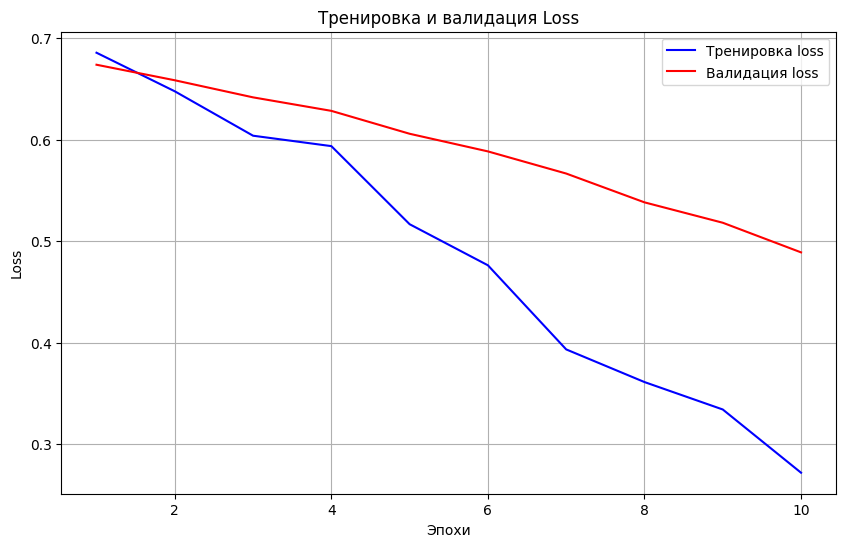

In [ ]:
plot_training_history(efficientnet_b0_history_15N['train_loss'], efficientnet_b0_history_15N['val_loss'], 'loss')

In [ ]:
benchmarks["efficientnet_b0_15N"] = efficientnet_b0_metrics_15N

<Figure size 1400x800 with 0 Axes>

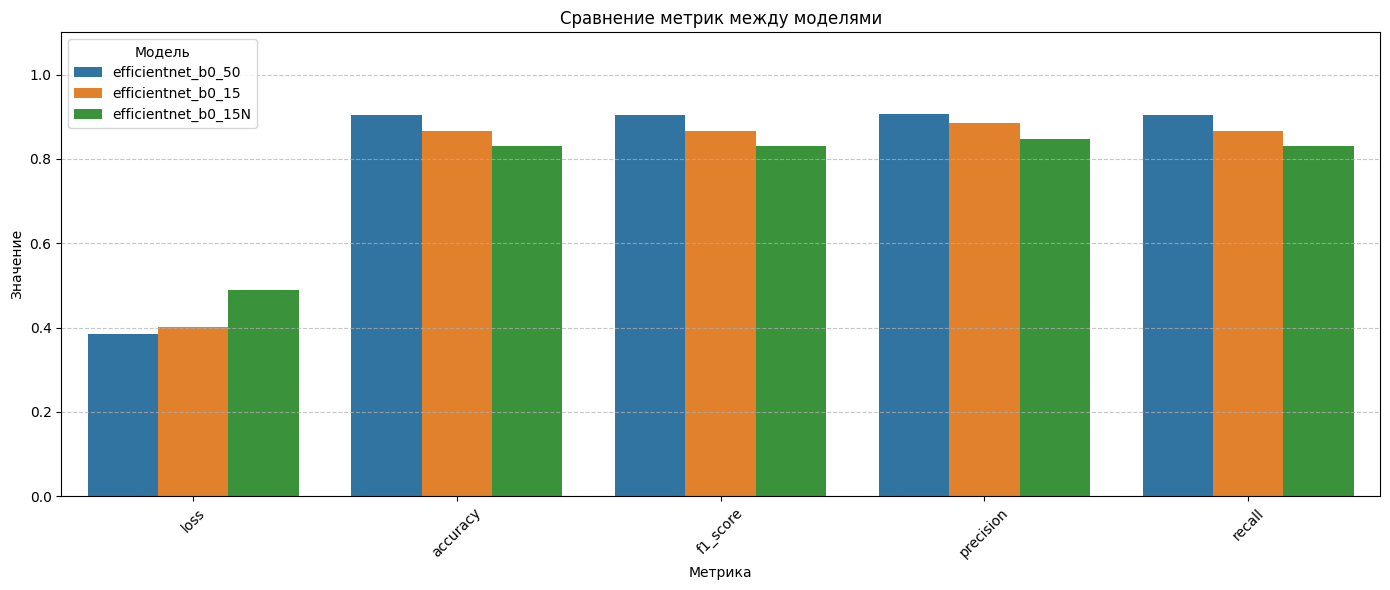

In [ ]:
comparison_df = compare_benchmarks(benchmarks)

Как и ожидалось, метрики стали чуть ниже, однако показатели остаются высоки!

*> 0,8 по каждому показателю*

### Новая модель

Заметим, что EfficentNet B0 занимает всего десятки мегабайт при обучении, а также совем не требовательна к размеру фотографий (224x224px), попробуем взять старшую модель из этого же семейства (B7, с 64M параметров), и посмотреть на тех же бенчмарках.

In [ ]:
# Загрузка названий классов из JSON
with open("/content/drive/MyDrive/classification/class_to_idx.json", "r")  as f:
  class_to_idx = json.load(f)

In [ ]:
directory_path = '/content/dataset'

if os.path.exists(directory_path):
    shutil.rmtree(directory_path)
    print(f"Директория {directory_path} успешно удалена.")
else:
    print(f"Директория {directory_path} не существует.")

Директория /content/dataset успешно удалена.


In [ ]:
local_zip = '/content/drive/MyDrive/classification/classification_dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/dataset')
zip_ref.close()

In [ ]:
train_loader, test_loader, train_dataset, test_dataset = create_dataloaders(
    train_dir='/content/dataset/classification_dataset/train',
    test_dir='/content/dataset/classification_dataset/test',
    hyperparams=hyperparams,
    target_size=50,
    image_size=600 # Модель B7 ожидает фотографии большего качества на вход
)

In [ ]:
# Загрузка модели EfficientNet
model = efficientnet_b7(EfficientNet_B7_Weights.DEFAULT)

# Заморозка всех слоев, кроме последнего
for param in model.parameters():
    param.requires_grad = False

# Замена финального классификатора
num_features = model.classifier[1].in_features
num_classes = len(class_to_idx)  # Количество классов из JSON
model.classifier = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Linear(128, num_classes),  # Многоклассовая классификация
    # На выходе оставляем сырые логиты, так как nn.CrossEntropyLoss() их ожидает на вход
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:02<00:00, 113MB/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()  # Для многоклассовой классификации
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=hyperparams['learning_rate'],
    weight_decay=hyperparams['weight_decay']
)

In [ ]:
# @title Текущее потребление памяти
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Максимальный объем памяти = {max_memory} ГБ.")
print(f"{start_gpu_memory} ГБ памяти зарезервировано.")

GPU = Tesla T4. Максимальный объем памяти = 14.741 ГБ.
0.332 ГБ памяти зарезервировано.


In [ ]:
start_time = time.time()

efficientnet_b7_history_50, efficientnet_b7_50 = train_model(
    model, train_loader, test_loader, criterion, optimizer,
    hyperparams['num_epochs'], device
)

train_runtime = time.time() - start_time

Epoch 1/10
Train Loss: 0.6735, Train Acc: 0.6900
Val Loss: 0.6239, Val Acc: 0.9770, Val F1: 0.9770, Precision: 0.9772, Recall: 0.9770
------------------------------------------------------------
Epoch 2/10
Train Loss: 0.6038, Train Acc: 0.8900
Val Loss: 0.5577, Val Acc: 0.9890, Val F1: 0.9890, Precision: 0.9890, Recall: 0.9890
------------------------------------------------------------
Epoch 3/10
Train Loss: 0.5353, Train Acc: 0.9000
Val Loss: 0.5070, Val Acc: 0.9920, Val F1: 0.9920, Precision: 0.9921, Recall: 0.9920
------------------------------------------------------------
Epoch 4/10
Train Loss: 0.4552, Train Acc: 0.9500
Val Loss: 0.4651, Val Acc: 0.9920, Val F1: 0.9920, Precision: 0.9920, Recall: 0.9920
------------------------------------------------------------
Epoch 5/10
Train Loss: 0.3879, Train Acc: 0.9200
Val Loss: 0.4288, Val Acc: 0.9930, Val F1: 0.9930, Precision: 0.9930, Recall: 0.9930
------------------------------------------------------------
Epoch 6/10
Train Loss: 0.

In [ ]:
# @title Потребление памяти после обучения
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_training = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
training_percentage = round(used_memory_for_training / max_memory * 100, 3)

# Выводим статистику
print(f"{train_runtime} секунд затрачено на обучение.")
print(
    f"{round(train_runtime/60, 2)} минут затрачено на обучение."
)
print(f"Пиковый объем зарезервированной памяти = {used_memory} ГБ.")
print(f"Пиковый объем зарезервированной памяти для обучения = {used_memory_for_training} ГБ.")
print(f"Пиковый объем зарезервированной памяти в % от максимальной памяти = {used_percentage} %.")
print(f"Пиковый объем зарезервированной памяти для обучения в % от максимальной памяти = {training_percentage} %.")

848.238906621933 секунд затрачено на обучение.
14.14 минут затрачено на обучение.
Пиковый объем зарезервированной памяти = 2.623 ГБ.
Пиковый объем зарезервированной памяти для обучения = 2.291 ГБ.
Пиковый объем зарезервированной памяти в % от максимальной памяти = 17.794 %.
Пиковый объем зарезервированной памяти для обучения в % от максимальной памяти = 15.542 %.


In [ ]:
efficientnet_b7_metrics_50 = evaluate_model(efficientnet_b7_50, test_loader, criterion, device)

In [ ]:
efficientnet_b7_metrics_50["confusion_matrix"]

array([[498,   2],
       [  5, 495]])

In [ ]:
efficientnet_b7_metrics_50["class_report"]

{'0': {'precision': 0.9900596421471173,
  'recall': 0.996,
  'f1-score': 0.9930209371884346,
  'support': 500.0},
 '1': {'precision': 0.9959758551307847,
  'recall': 0.99,
  'f1-score': 0.9929789368104313,
  'support': 500.0},
 'accuracy': 0.993,
 'macro avg': {'precision': 0.993017748638951,
  'recall': 0.993,
  'f1-score': 0.9929999369994329,
  'support': 1000.0},
 'weighted avg': {'precision': 0.993017748638951,
  'recall': 0.993,
  'f1-score': 0.992999936999433,
  'support': 1000.0}}

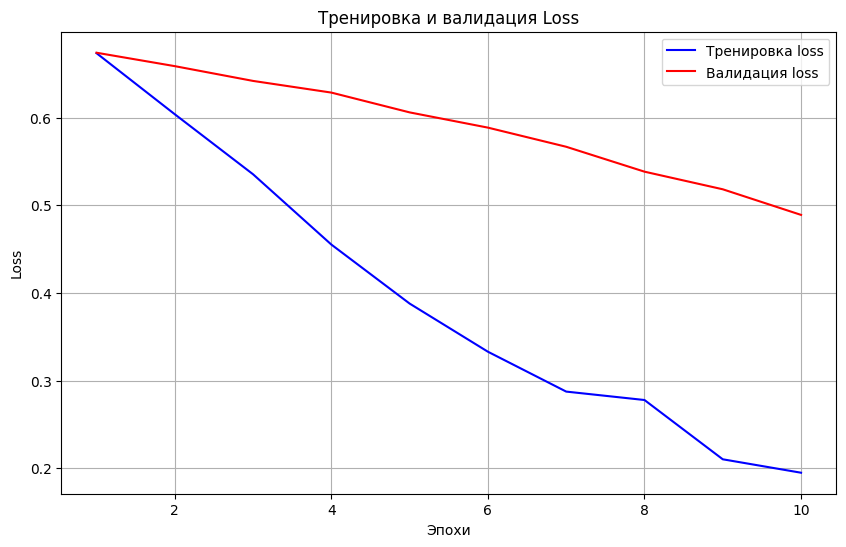

In [ ]:
plot_training_history(efficientnet_b7_history_50['train_loss'], efficientnet_b0_history_15N['val_loss'], 'loss')

In [ ]:
benchmarks["efficientnet_b7_50"] = efficientnet_b7_metrics_50

<Figure size 1400x800 with 0 Axes>

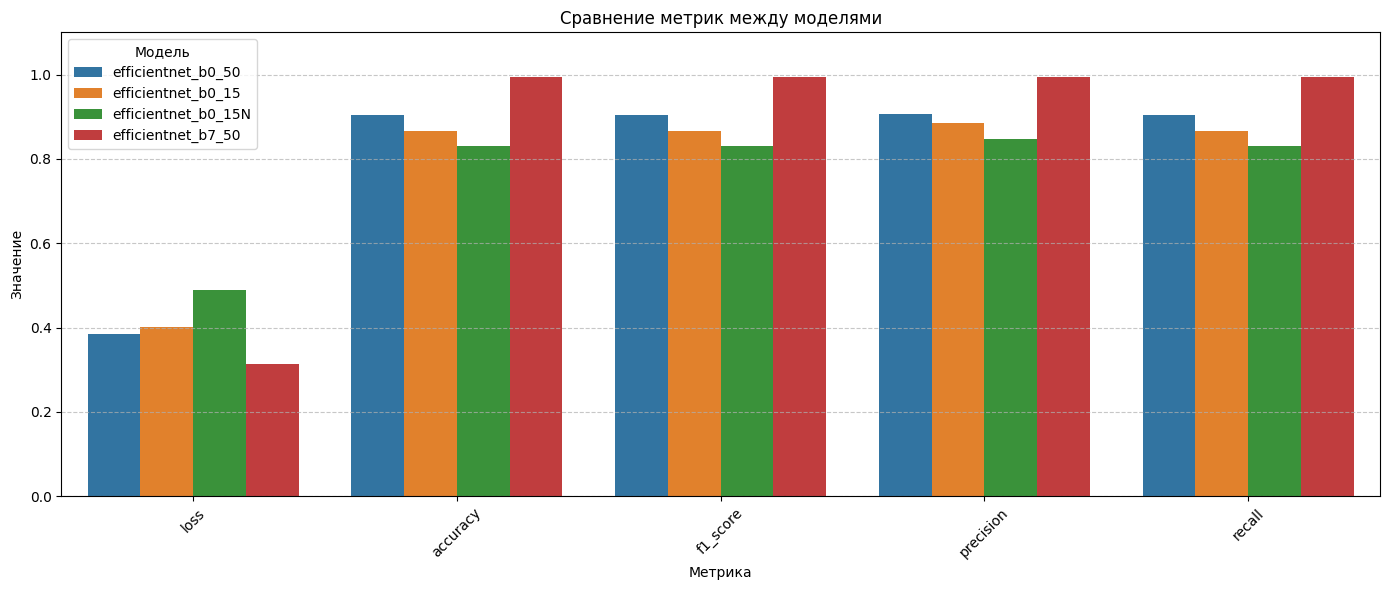

In [ ]:
comparison_df = compare_benchmarks(benchmarks)

Поразительные метрики! Но также заметим, что памяти было занято более чем в 10 раз, попробуем еще на неизвестных модели классов и их малым кол-вом, все те же Tom Hanks и Tom Cruise

In [ ]:
# Загрузка новых названий классов из JSON
with open("/content/drive/MyDrive/classification/class_to_idx_celebrity.json", "r")  as f:
  class_to_idx = json.load(f)

In [ ]:
directory_path = '/content/dataset'

if os.path.exists(directory_path):
    shutil.rmtree(directory_path)
    print(f"Директория {directory_path} успешно удалена.")
else:
    print(f"Директория {directory_path} не существует.")

Директория /content/dataset успешно удалена.


In [ ]:
local_zip = '/content/drive/MyDrive/classification/classification_dataset_selebrity.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/dataset')
zip_ref.close()

In [ ]:
train_loader, test_loader, train_dataset, test_dataset = create_dataloaders(
    train_dir='/content/dataset/classification_dataset/train',
    test_dir='/content/dataset/classification_dataset/test',
    hyperparams=hyperparams,
    target_size=50,
    image_size=600
)

In [ ]:
# Загрузка модели EfficientNet
model = efficientnet_b7(EfficientNet_B7_Weights.DEFAULT)

# Заморозка всех слоев, кроме последнего
for param in model.parameters():
    param.requires_grad = False

# Замена финального классификатора
num_features = model.classifier[1].in_features
num_classes = len(class_to_idx)  # Количество классов из JSON
model.classifier = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Linear(128, num_classes),  # Многоклассовая классификация
    # На выходе оставляем сырые логиты, так как nn.CrossEntropyLoss() их ожидает на вход
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()  # Для многоклассовой классификации
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=hyperparams['learning_rate'],
    weight_decay=hyperparams['weight_decay']
)

In [ ]:
efficientnet_b7_history_15N, efficientnet_b7_15N = train_model(
    model, train_loader, test_loader, criterion, optimizer,
    hyperparams['num_epochs'], device
)

Epoch 1/10
Train Loss: 0.6848, Train Acc: 0.5000
Val Loss: 0.6970, Val Acc: 0.5141, Val F1: 0.4726, Precision: 0.5051, Recall: 0.5141
------------------------------------------------------------
Epoch 2/10
Train Loss: 0.6294, Train Acc: 0.6800
Val Loss: 0.6866, Val Acc: 0.6158, Val F1: 0.5910, Precision: 0.6380, Recall: 0.6158
------------------------------------------------------------
Epoch 3/10
Train Loss: 0.5572, Train Acc: 0.9400
Val Loss: 0.6789, Val Acc: 0.6893, Val F1: 0.6770, Precision: 0.7116, Recall: 0.6893
------------------------------------------------------------
Epoch 4/10
Train Loss: 0.5344, Train Acc: 0.9000
Val Loss: 0.6693, Val Acc: 0.7175, Val F1: 0.7042, Precision: 0.7514, Recall: 0.7175
------------------------------------------------------------
Epoch 5/10
Train Loss: 0.4508, Train Acc: 0.9800
Val Loss: 0.6561, Val Acc: 0.7514, Val F1: 0.7422, Precision: 0.7812, Recall: 0.7514
------------------------------------------------------------
Epoch 6/10
Train Loss: 0.

In [ ]:
efficientnet_b7_metrics_15N = evaluate_model(efficientnet_b7_15N, test_loader, criterion, device)

In [ ]:
benchmarks["efficientnet_b7_15N"] = efficientnet_b7_metrics_15N

<Figure size 1400x800 with 0 Axes>

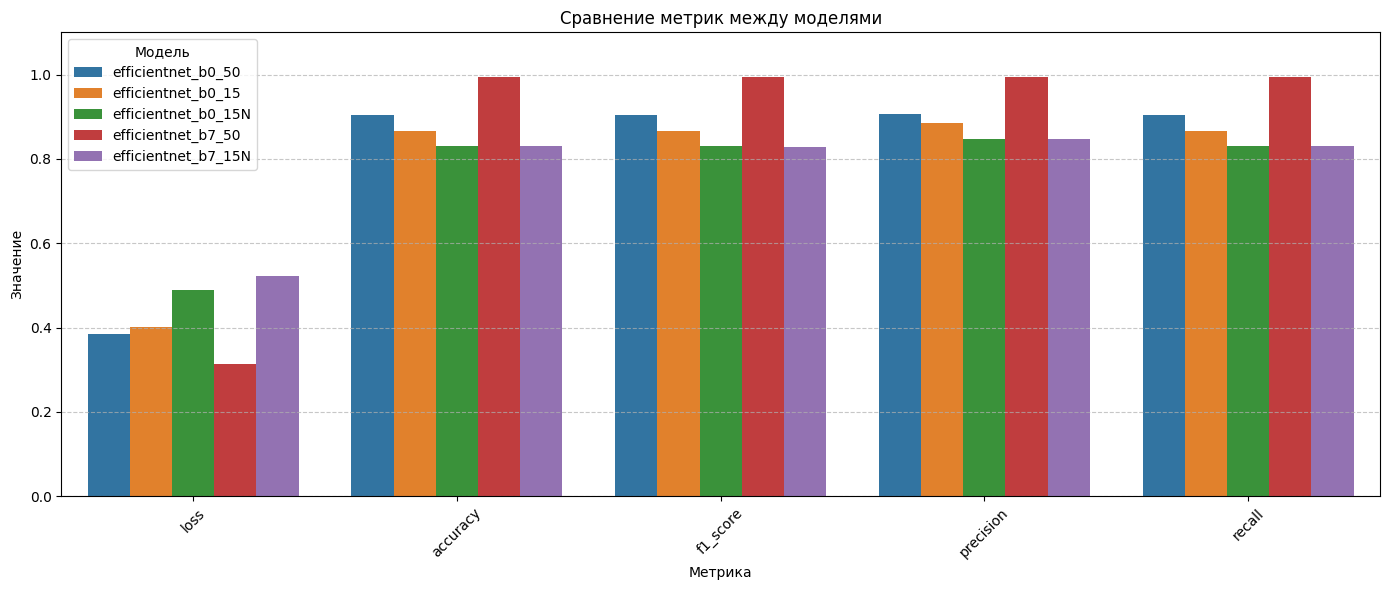

In [ ]:
comparison_df = compare_benchmarks(benchmarks)

Метрики на том же уровне, что и у младшей модели, заметим, что лосс на валидации не упал до плато, поэтому попробуем обучится еще на 10 эпохах.

In [ ]:
efficientnet_b7_history_15N, efficientnet_b7_15N = train_model(
    model, train_loader, test_loader, criterion, optimizer,
    hyperparams['num_epochs'], device
)

Epoch 1/10
Train Loss: 0.2865, Train Acc: 0.9400
Val Loss: 0.4954, Val Acc: 0.8418, Val F1: 0.8395, Precision: 0.8555, Recall: 0.8418
------------------------------------------------------------
Epoch 2/10
Train Loss: 0.1936, Train Acc: 0.9800
Val Loss: 0.4648, Val Acc: 0.8588, Val F1: 0.8569, Precision: 0.8716, Recall: 0.8588
------------------------------------------------------------
Epoch 3/10
Train Loss: 0.2214, Train Acc: 0.9800
Val Loss: 0.4401, Val Acc: 0.8701, Val F1: 0.8687, Precision: 0.8803, Recall: 0.8701
------------------------------------------------------------
Epoch 4/10
Train Loss: 0.2043, Train Acc: 0.9900
Val Loss: 0.4228, Val Acc: 0.8701, Val F1: 0.8687, Precision: 0.8803, Recall: 0.8701
------------------------------------------------------------
Epoch 5/10
Train Loss: 0.1390, Train Acc: 1.0000
Val Loss: 0.4063, Val Acc: 0.8757, Val F1: 0.8745, Precision: 0.8847, Recall: 0.8757
------------------------------------------------------------
Epoch 6/10
Train Loss: 0.

In [ ]:
benchmarks["efficientnet_b7_15N"] = efficientnet_b7_metrics_15N

<Figure size 1400x800 with 0 Axes>

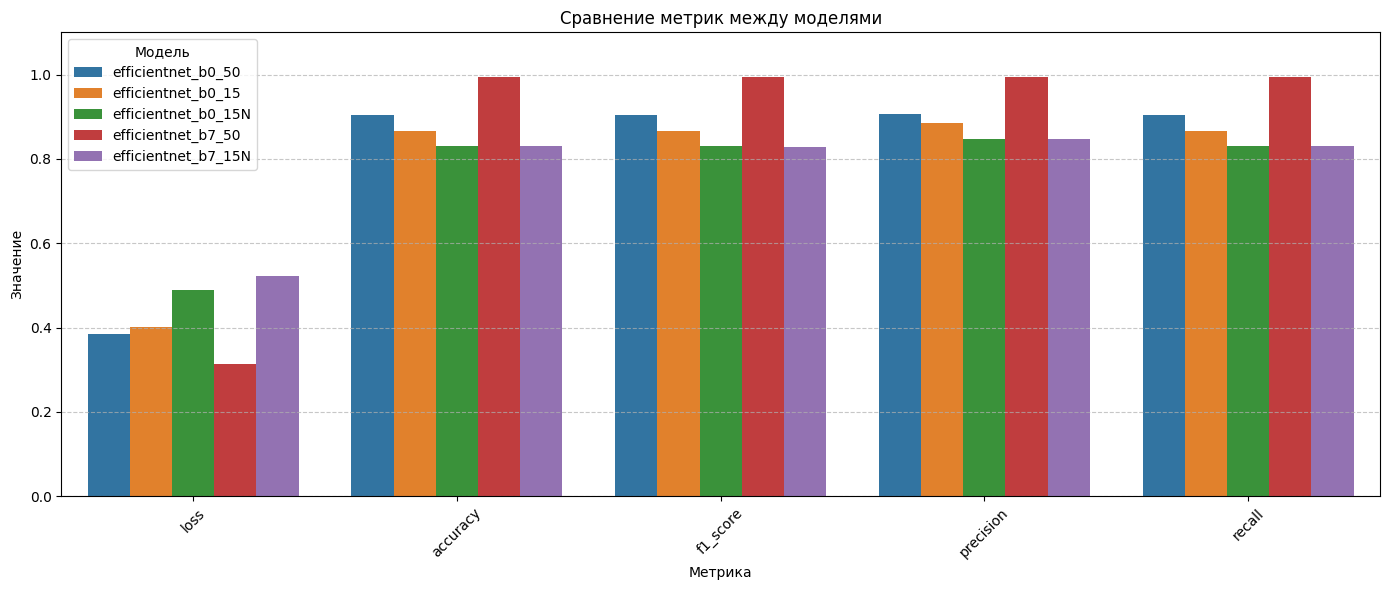

In [ ]:
comparison_df = compare_benchmarks(benchmarks)

Метрики также идентичны, что означает слишком малую выборку тренирово

In [ ]:
# Сохранение модели
torch.save(model, '/content/trained_model_classification.pt')

# Копирование на Google Drive
!cp "/content/trained_model_classification.pt" "/content/drive/MyDrive/classification/trained_model_classification.pt"
print("Модель сохранена")